# urban audit for students

Can we find clusters of comparable university cities in Germany with similar venues?

In [1]:
# Import the libraries we need
from bs4 import BeautifulSoup

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance_matrix 

from matplotlib import pyplot as plt 
%matplotlib inline

import pylab


print('Libraries imported.')

Libraries imported.


## 1. Get a list of universities


A list of German universities per faculty is available at the page: www.studieren.de.
We're only interested in the cities, where you can study mathematics.

In [2]:
page_link = 'https://studieren.de/mathematik.fachbereiche.t-0.f-44.html'
page_response = requests.get(page_link).text
soup = BeautifulSoup(page_response, 'lxml')
#print(soup.prettify())

In [3]:
data = []
Cities = soup.findAll('span', class_='location-item')
for row in Cities[:-1]:
    col = row.text[:-2]
    data.append(col) # Get rid of empty values
data.append(Cities[len(Cities)-1].text) 

This is a list of all city names with a mathematical faculty. In the next step I define a dataframe with the city names and fill it also with the latitude and longitude values from the Nominatim package.

In [4]:
col_names = ['City', 'Latitude', 'Longitude']
university_location = pd.DataFrame(columns = col_names)
for city in data:
    address = city
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    # print('The geograpical coordinate of {} are {}, {}.'.format(city, latitude, longitude))
    university_location.loc[len(university_location)]=[address, latitude, longitude]


In [5]:
university_location.head(10)

,City,Latitude,Longitude
0,Aachen,50.776351,6.083862
1,Augsburg,48.366804,10.898697
2,Bamberg,49.892672,10.887615
3,Bayreuth,49.942720,11.576308
4,Berlin,52.517037,13.388860
5,Bielefeld,52.010877,8.540868
6,Bochum,51.481811,7.219664
7,Bonn,50.735851,7.100660
8,Braunschweig,52.264658,10.523607
9,Bremen,53.075820,8.807165


Let's plot a map with all universities where you can study mathematics in Germany:

In [6]:
# Latitude and Longitude from the middel of Germany
latitude = 51.165691
longitude = 10.451526

map_german_math_uni = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, city in zip(university_location['Latitude'], university_location['Longitude'], university_location['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_german_math_uni)  
    
map_german_math_uni

## 2. Get information of venues in the university cities

Now I use the Foursquare API to get the venues in the university cities.

Define the credentials and version: 

In [7]:
CLIENT_ID = 'RJMH2NTRI1NVM0Z5DECCOKTR4DRLFCQ0GA5LDPJIIBXCC54I' # your Foursquare ID
CLIENT_SECRET = 'CRVBC2QSRBYRBIA11RG1YBBAKWOKQQ05QS3RXACXJZWETHN4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [8]:
# function that extracts the venues for each city

def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now run the code for all cities to get up to 100 venues in the city:

In [9]:
math_city_venues = getNearbyVenues(names=university_location['City'],
                                   latitudes=university_location['Latitude'],
                                   longitudes=university_location['Longitude']
                                  )


How many venues do we have in total?

In [10]:
math_city_venues.shape
#math_city_venues.head(20)

(6182, 7)

How many venues do we receive for each city?

In [11]:
math_city_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Aachen,100,100,100,100,100,100
Augsburg,100,100,100,100,100,100
Bamberg,64,64,64,64,64,64
Bayreuth,86,86,86,86,86,86
Berlin,100,100,100,100,100,100
Bielefeld,87,87,87,87,87,87
Bochum,100,100,100,100,100,100
Bonn,100,100,100,100,100,100
Braunschweig,100,100,100,100,100,100


### Let's find out what's in Bremen

In [12]:
br_venues = math_city_venues[math_city_venues.City=='Bremen']
br_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
837,Bremen,53.07582,8.807165,Marktplatz,53.075882,8.807210,Plaza
838,Bremen,53.07582,8.807165,Rathaus Bremen / Bremen Town Hall (Rathaus Bre...,53.075841,8.807328,City Hall
839,Bremen,53.07582,8.807165,Atlantic Grand Hotel Bremen,53.075446,8.804802,Hotel
840,Bremen,53.07582,8.807165,Schnoorviertel,53.072996,8.809233,Neighborhood
841,Bremen,53.07582,8.807165,Schlachte,53.077190,8.801165,Waterfront


In [13]:
print('There are {} uniques categories.'.format(len(br_venues['Venue Category'].unique())))

There are 58 uniques categories.


In [14]:
# Latitude and Longitude from Bremen
latitude = 53.075820
longitude = 8.807165 

map_bremen = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, venue, cat in zip(br_venues['Venue Latitude'], br_venues['Venue Longitude'], br_venues['Venue'], br_venues['Venue Category']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bremen)  
    
map_bremen

### Back to the whole dataset

Let's find out how many unique categories there are in Germany:

In [15]:
print('There are {} uniques categories.'.format(len(math_city_venues['Venue Category'].unique())))

There are 328 uniques categories.


To get frequencies of venues per city we have to get "True"-/"False"-Value for each category:

In [16]:
# one hot encoding
math_city_onehot = pd.get_dummies(math_city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
math_city_onehot['City'] = math_city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [math_city_onehot.columns[-1]] + list(math_city_onehot.columns[:-1])
math_city_onehot = math_city_onehot[fixed_columns]

math_city_onehot.head()
#math_city_onehot.shape

,City,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,...,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aachen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aachen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aachen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aachen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's get a mean for each category in each city:

In [17]:
math_city_grouped = math_city_onehot.groupby('City').mean().reset_index()
math_city_grouped.head()

,City,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,...,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,...,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.00,0.00,0.0
1,Augsburg,0.0,0.0,0.0,0.0,0.000000,0.000000,0.01,0.0,0.0,...,0.01,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.01,0.0
2,Bamberg,0.0,0.0,0.0,0.0,0.015625,0.000000,0.00,0.0,0.0,...,0.00,0.0,0.015625,0.0,0.0,0.00,0.0,0.00,0.00,0.0
3,Bayreuth,0.0,0.0,0.0,0.0,0.000000,0.011628,0.00,0.0,0.0,...,0.00,0.0,0.011628,0.0,0.0,0.00,0.0,0.00,0.00,0.0
4,Berlin,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,...,0.00,0.0,0.000000,0.0,0.0,0.02,0.0,0.01,0.00,0.0


Afterwards we have a value for each city and category:

In [18]:
math_city_grouped.shape

(75, 329)

For the k-means algorithm we create a new list with the top 10 venues per city:

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = math_city_grouped['City']

for ind in np.arange(math_city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(math_city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Café,Bar,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bakery,Park,Supermarket,Plaza,Ice Cream Shop
1,Augsburg,Italian Restaurant,Café,Steakhouse,Bar,Beer Garden,German Restaurant,Hotel,Bakery,Pub,Turkish Restaurant
2,Bamberg,Café,German Restaurant,Supermarket,Hotel,Beer Garden,Brewery,Park,Plaza,Pub,Pool
3,Bayreuth,Supermarket,Italian Restaurant,German Restaurant,Big Box Store,Café,Drugstore,Bar,Bakery,Opera House,Brewery
4,Berlin,Coffee Shop,Bookstore,Ice Cream Shop,Concert Hall,Park,Art Gallery,Garden,Vegetarian / Vegan Restaurant,Science Museum,Hotel


### And for Bremen:

In [21]:
city_venues_sorted[city_venues_sorted.City=='Bremen']

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Bremen,Café,Hotel,German Restaurant,Bar,Italian Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Burger Joint,Market,Asian Restaurant


## 3. Cluster Cities

### 3.1 k-means

At first I use k-means to build clusters of similar cities and explore the results. I tried different numbers of clusters between 3 and 10 but 5-7 were the interesting results (not too big and not to many very small clusters).

In [22]:
# set number of clusters
kclusters = 7

math_city_grouped_clustering = math_city_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(math_city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 5, 1, 2, 4, 4, 4, 4, 4], dtype=int32)

In [23]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

math_city_merged = university_location

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
math_city_merged = math_city_merged.join(city_venues_sorted.set_index('City'), on='City')

math_city_merged.head(10) # check the last columns!

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,50.776351,6.083862,4,Café,Bar,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bakery,Park,Supermarket,Plaza,Ice Cream Shop
1,Augsburg,48.366804,10.898697,4,Italian Restaurant,Café,Steakhouse,Bar,Beer Garden,German Restaurant,Hotel,Bakery,Pub,Turkish Restaurant
2,Bamberg,49.892672,10.887615,5,Café,German Restaurant,Supermarket,Hotel,Beer Garden,Brewery,Park,Plaza,Pub,Pool
3,Bayreuth,49.942720,11.576308,1,Supermarket,Italian Restaurant,German Restaurant,Big Box Store,Café,Drugstore,Bar,Bakery,Opera House,Brewery
4,Berlin,52.517037,13.388860,2,Coffee Shop,Bookstore,Ice Cream Shop,Concert Hall,Park,Art Gallery,Garden,Vegetarian / Vegan Restaurant,Science Museum,Hotel
5,Bielefeld,52.010877,8.540868,4,Bar,Supermarket,Restaurant,Café,Burger Joint,Hotel,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Park
6,Bochum,51.481811,7.219664,4,Bakery,Café,Supermarket,Park,Event Space,Sushi Restaurant,Bar,Ice Cream Shop,Market,Asian Restaurant
7,Bonn,50.735851,7.100660,4,Café,German Restaurant,Pub,Italian Restaurant,Plaza,Museum,Burger Joint,Movie Theater,Korean Restaurant,Coffee Shop
8,Braunschweig,52.264658,10.523607,4,Café,Italian Restaurant,Bar,Park,Turkish Restaurant,Plaza,Coffee Shop,Pizza Place,Steakhouse,Restaurant
9,Bremen,53.075820,8.807165,4,Café,Hotel,German Restaurant,Bar,Italian Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Burger Joint,Market,Asian Restaurant


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(math_city_merged['Latitude'], math_city_merged['Longitude'], math_city_merged['City'], math_city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In [25]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 0, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Eichstätt,Supermarket,German Restaurant,Other Great Outdoors,Drugstore,Pub,Gym,Hotel,Garden Center,Fast Food Restaurant,Hardware Store


In [26]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 1, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bayreuth,Supermarket,Italian Restaurant,German Restaurant,Big Box Store,Café,Drugstore,Bar,Bakery,Opera House,Brewery
10,Chemnitz,Supermarket,Drugstore,German Restaurant,Café,Gym / Fitness Center,Hotel,Cocktail Bar,Pizza Place,Asian Restaurant,College Gym
12,Cottbus,Supermarket,Hotel,Drugstore,German Restaurant,Café,Park,Gas Station,Fast Food Restaurant,Shopping Mall,Movie Theater
18,Erfurt,Café,Supermarket,Drugstore,Plaza,German Restaurant,Big Box Store,Hardware Store,Ice Cream Shop,Park,Restaurant
22,Freiberg,Drugstore,Supermarket,Café,Gas Station,Greek Restaurant,History Museum,German Restaurant,Fast Food Restaurant,Shopping Mall,Eastern European Restaurant
24,Friedberg,Supermarket,Bakery,Drugstore,Asian Restaurant,Big Box Store,Gas Station,Hotel,Furniture / Home Store,Italian Restaurant,River
26,Göttingen,Café,Supermarket,Hotel,Italian Restaurant,Greek Restaurant,German Restaurant,Bar,Gym / Fitness Center,Steakhouse,Big Box Store
27,Greifswald,Supermarket,Café,Gas Station,Drugstore,Fast Food Restaurant,German Restaurant,Seafood Restaurant,Hotel,Bakery,Shopping Mall
28,Hagen,Supermarket,Clothing Store,Bakery,Drugstore,Greek Restaurant,Italian Restaurant,Hotel,Gas Station,Gym / Fitness Center,Shopping Mall
29,Halle (Saale),Supermarket,Café,Gas Station,Drugstore,German Restaurant,Plaza,Bar,Hotel,Big Box Store,Multiplex


In [27]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 2, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Berlin,Coffee Shop,Bookstore,Ice Cream Shop,Concert Hall,Park,Art Gallery,Garden,Vegetarian / Vegan Restaurant,Science Museum,Hotel
30,Hamburg,Café,Coffee Shop,Hotel,French Restaurant,Steakhouse,Restaurant,Ice Cream Shop,Vietnamese Restaurant,Park,Seafood Restaurant
31,Hannover,Coffee Shop,Café,Steakhouse,Pub,Hotel,Burger Joint,Pizza Place,Irish Pub,Breakfast Spot,Theater


In [28]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 3, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Mittweida,Supermarket,Pizza Place,Gas Station,Big Box Store,Hotel,General Entertainment,Gym,Drugstore,Eastern European Restaurant,Dessert Shop


In [29]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 4, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Café,Bar,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bakery,Park,Supermarket,Plaza,Ice Cream Shop
1,Augsburg,Italian Restaurant,Café,Steakhouse,Bar,Beer Garden,German Restaurant,Hotel,Bakery,Pub,Turkish Restaurant
5,Bielefeld,Bar,Supermarket,Restaurant,Café,Burger Joint,Hotel,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Park
6,Bochum,Bakery,Café,Supermarket,Park,Event Space,Sushi Restaurant,Bar,Ice Cream Shop,Market,Asian Restaurant
7,Bonn,Café,German Restaurant,Pub,Italian Restaurant,Plaza,Museum,Burger Joint,Movie Theater,Korean Restaurant,Coffee Shop
8,Braunschweig,Café,Italian Restaurant,Bar,Park,Turkish Restaurant,Plaza,Coffee Shop,Pizza Place,Steakhouse,Restaurant
9,Bremen,Café,Hotel,German Restaurant,Bar,Italian Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Burger Joint,Market,Asian Restaurant
13,Darmstadt,Café,Italian Restaurant,German Restaurant,Middle Eastern Restaurant,Supermarket,Organic Grocery,Park,Beer Garden,Sushi Restaurant,Bar
14,Dortmund,Café,Italian Restaurant,German Restaurant,Coffee Shop,Pub,Turkish Restaurant,Trattoria/Osteria,Japanese Restaurant,Sushi Restaurant,Bar
16,Düsseldorf,Japanese Restaurant,Hotel,Coffee Shop,Brewery,Grocery Store,Plaza,Bar,Park,Dessert Shop,Art Museum


In [30]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 5, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bamberg,Café,German Restaurant,Supermarket,Hotel,Beer Garden,Brewery,Park,Plaza,Pub,Pool
15,Dresden,Hotel,German Restaurant,Art Museum,Plaza,Coffee Shop,Historic Site,Scenic Lookout,Shopping Mall,Science Museum,Café
19,Erlangen,German Restaurant,Café,Italian Restaurant,Supermarket,Beer Garden,Bakery,Greek Restaurant,Pizza Place,Drugstore,Trattoria/Osteria
23,Freiburg,Café,German Restaurant,Hotel,Plaza,Italian Restaurant,Restaurant,Tapas Restaurant,Brewery,Indian Restaurant,Deli / Bodega
25,Gießen,Supermarket,Café,Hotel,German Restaurant,Italian Restaurant,Lake,Gas Station,Nightclub,Salad Place,Restaurant
33,Hildesheim,Café,German Restaurant,Supermarket,Gym / Fitness Center,Hotel,Drugstore,Italian Restaurant,Ice Cream Shop,Pub,Indian Restaurant
35,Jena,Café,German Restaurant,Hotel,Supermarket,Fast Food Restaurant,Bar,Plaza,Train Station,Falafel Restaurant,Steakhouse
36,Kaiserslautern,Café,German Restaurant,Hotel,Drugstore,Furniture / Home Store,Supermarket,Bar,Clothing Store,Fried Chicken Joint,Electronics Store
42,Konstanz,Café,Hotel,German Restaurant,Coffee Shop,Train Station,Swiss Restaurant,Ice Cream Shop,Park,Indian Restaurant,Italian Restaurant
45,Lübeck,Hotel,Supermarket,Café,Gas Station,German Restaurant,Seafood Restaurant,Plaza,Drugstore,Fast Food Restaurant,Italian Restaurant


In [31]:
math_city_merged.loc[math_city_merged['Cluster Labels'] == 6, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Clausthal-Zellerfeld,Italian Restaurant,Gas Station,Hotel,Gym / Fitness Center,Supermarket,Drugstore,Fast Food Restaurant,Cafeteria,Lake,Big Box Store


Bremen is in the 5th cluster, which is relative big:

In [32]:
len(math_city_merged.loc[math_city_merged['Cluster Labels'] == 4, math_city_merged.columns[[0] + list(range(4, math_city_merged.shape[1]))]])

27

We have 27 quite similar cities and could now give a first recommendation to a student in Bremen where to find related venues:

In [33]:
print(math_city_merged.loc[math_city_merged['Cluster Labels'] == 4, 'City'])

0              Aachen
1            Augsburg
5           Bielefeld
6              Bochum
7                Bonn
8        Braunschweig
9              Bremen
13          Darmstadt
14           Dortmund
16         Düsseldorf
20              Essen
21    Frankfurt a. M.
32         Heidelberg
37          Karlsruhe
38             Kassel
39               Kiel
41               Köln
44            Leipzig
47              Mainz
48           Mannheim
51            München
52            Münster
54           Nürnberg
59            Potsdam
64        Saarbrücken
67          Stuttgart
72          Wiesbaden
Name: City, dtype: object


### 3.2 hierarchical Clustering

To better understand who is the best choice for a very likely city I use hierarchical clustering and plot the dendogramm. Now I have to use the table with the percentage of categories for each city:

In [34]:
math_city_grouped.head()

,City,ATM,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,...,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,...,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.00,0.00,0.0
1,Augsburg,0.0,0.0,0.0,0.0,0.000000,0.000000,0.01,0.0,0.0,...,0.01,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.01,0.0
2,Bamberg,0.0,0.0,0.0,0.0,0.015625,0.000000,0.00,0.0,0.0,...,0.00,0.0,0.015625,0.0,0.0,0.00,0.0,0.00,0.00,0.0
3,Bayreuth,0.0,0.0,0.0,0.0,0.000000,0.011628,0.00,0.0,0.0,...,0.00,0.0,0.011628,0.0,0.0,0.00,0.0,0.00,0.00,0.0
4,Berlin,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,...,0.00,0.0,0.000000,0.0,0.0,0.02,0.0,0.01,0.00,0.0


In [35]:
D = math_city_grouped[math_city_grouped.columns[list(range(1, math_city_grouped.shape[1]))]]
Z = hierarchy.linkage(D, 'complete')

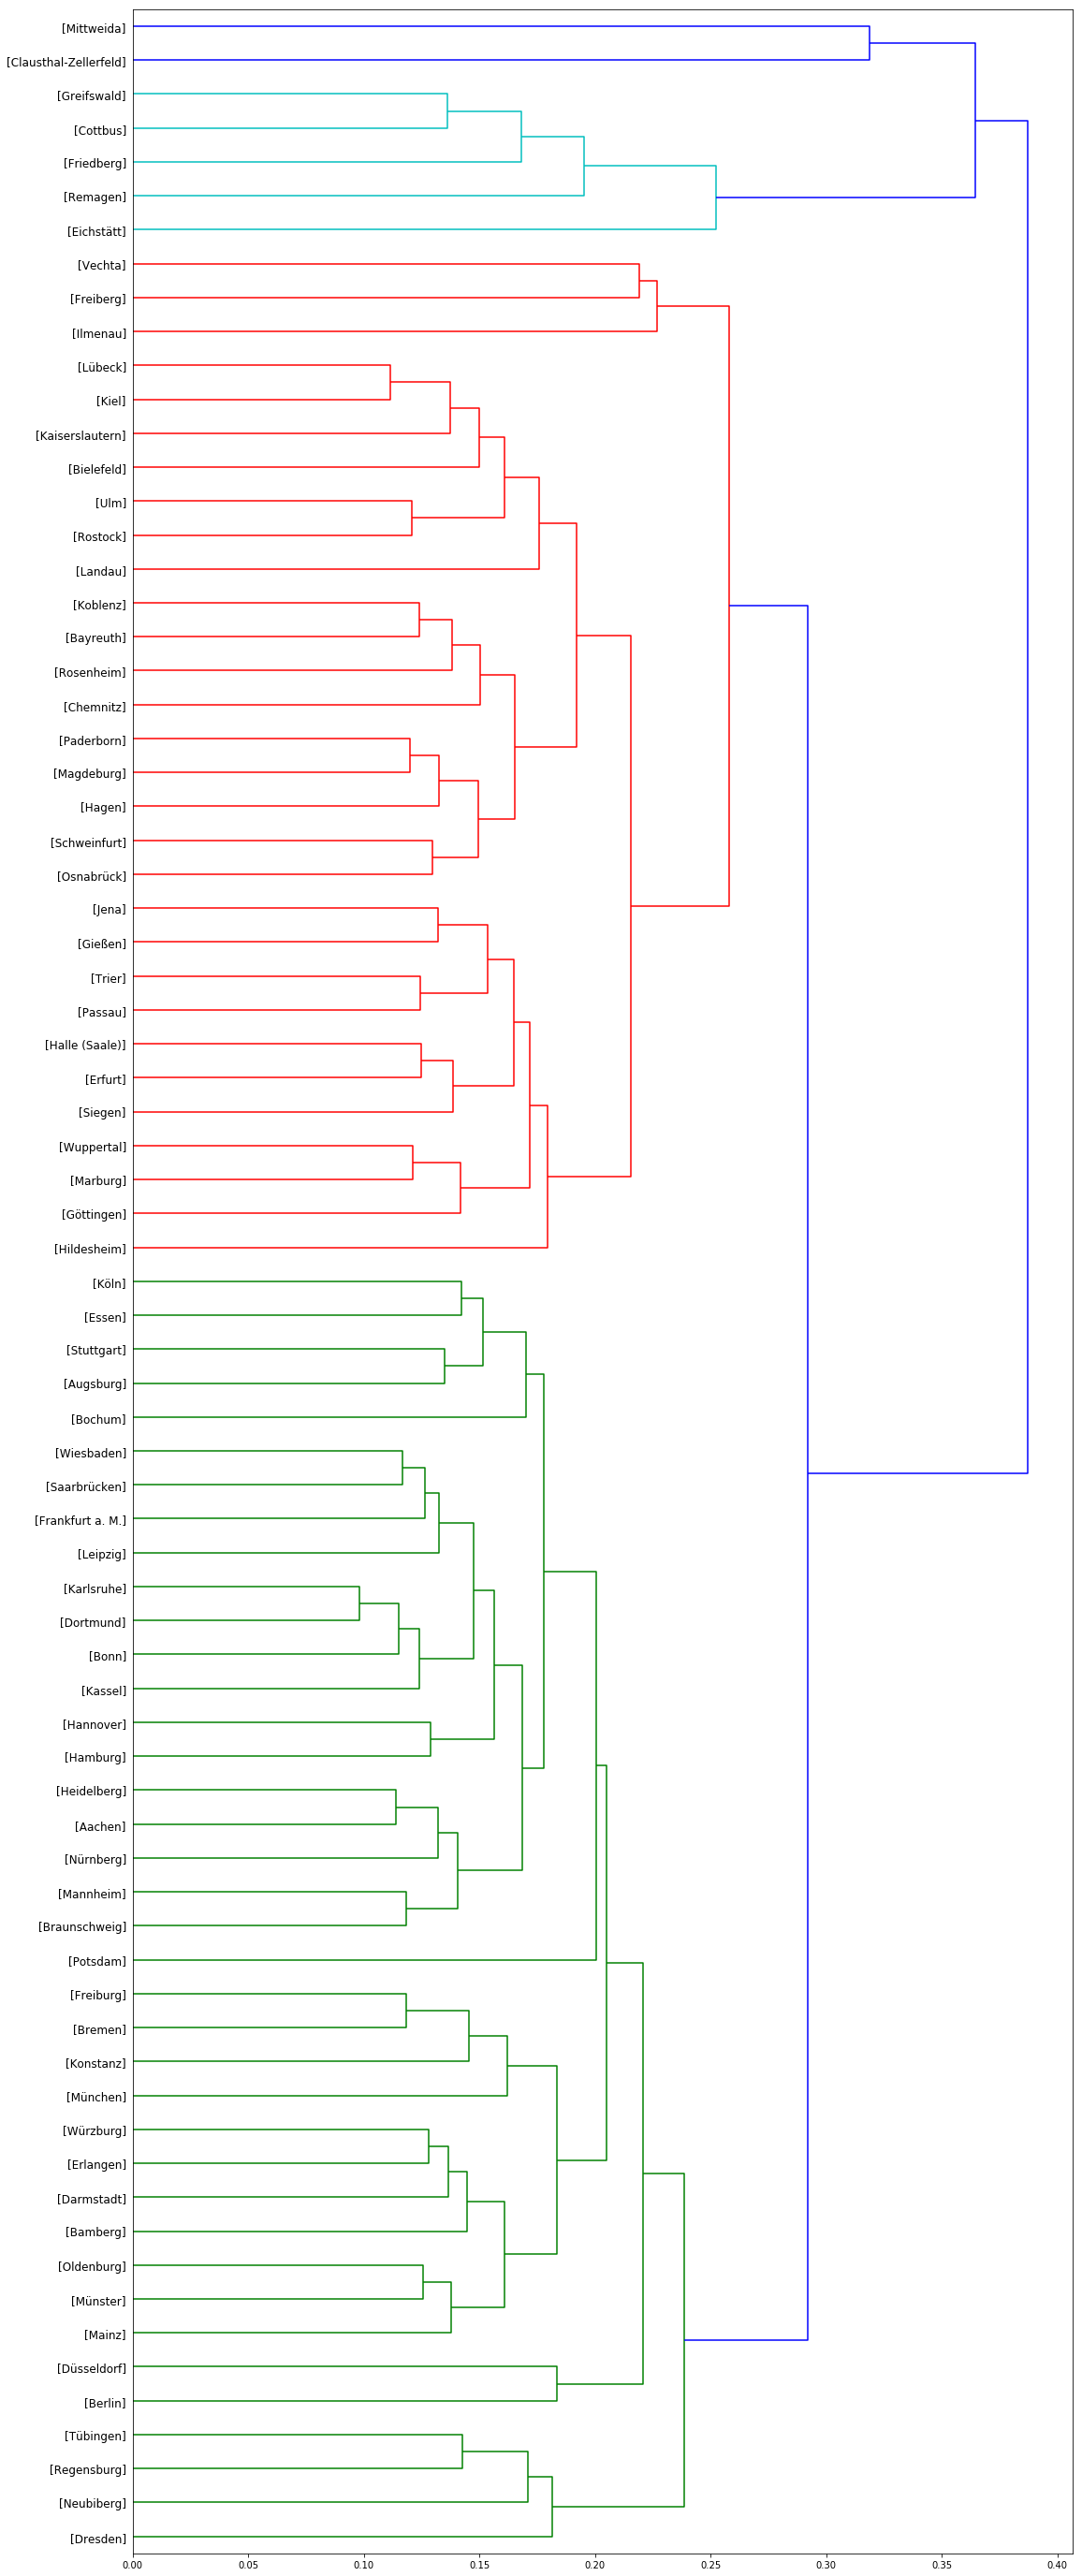

In [36]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (math_city_grouped['City'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

We can see that the most similar city is Freiburg and then Konstanz. So we could give a more specific proposal for the students.